In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
import random

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R01CS", "R02N"]

dtype = torch.float32

In [3]:
sequences = []
for round_id in round_ids:
    sequences.append(utils.sequences_from_file(experiment_id, round_id))
    print(f"Finished round {round_id}")

Finished round ARN
Finished round R01
Finished round R01CS
Finished round R02N


In [4]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [5]:
sequences.clear()

In [6]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [7]:
L, q = sequences_oh[0][0].shape

k = torch.randn(L, q, dtype=dtype) * 1e-4
h_beads = torch.randn(L, q, dtype=dtype) * 1e-4
h = torch.randn(L, q, dtype=dtype) * 1e-4
# J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor(
    [[1, 1, 0],
     [0, 1, 0],
     [1, 1, 0]]
)

Ns0 = energy_models.IndepSites(k)
# potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
beads = energy_models.IndepSites(h_beads)
unbound_sel = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(indep, beads, unbound_sel, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [8]:
device = torch.device("cpu")

In [9]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [10]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [11]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [19]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 500

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                         ] Epoch: 0/500 [00:00, ?it/s]

In [20]:
import torch
import gc

# Force garbage collection
gc.collect()

# Check GPU memory if using CUDA
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB allocated")
        print(f"GPU {i}: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB reserved")

# List large tensor objects
tensors = [obj for obj in gc.get_objects() if torch.is_tensor(obj)]
total_size = 0
for t in sorted(tensors, key=lambda x: x.element_size() * x.nelement(), reverse=True)[:20]:
    size_gb = (t.element_size() * t.nelement()) / 1e9
    total_size += size_gb
    print(f"{size_gb:.3f} GB - {t.shape} {t.dtype} on {t.device}")

print(f"\nTotal tensor size: {total_size:.2f} GB")

12.363 GB - torch.Size([17170200, 45, 4]) torch.float32 on cpu
10.231 GB - torch.Size([14210281, 45, 4]) torch.float32 on cpu
7.029 GB - torch.Size([9763154, 45, 4]) torch.float32 on cpu
3.736 GB - torch.Size([5189558, 45, 4]) torch.float32 on cpu
0.029 GB - torch.Size([4, 10000, 45, 4]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 GB - torch.Size([10000, 180]) torch.float32 on cpu
0.007 

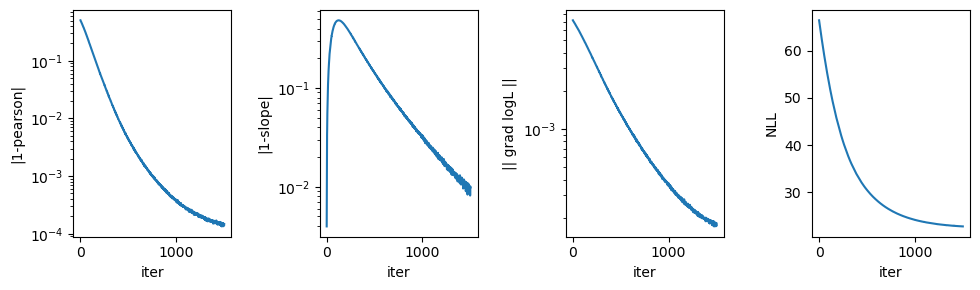

In [21]:
callbacks[0].plot();

## SAVE MODEL TO FILE

In [22]:
torch.save(model, 'experiments/saved/dataset_1_beads.pt')

In [ ]:
# fig, ax = callbacks[1].plot()
# ax.axhline(1, color='r', linestyle='--')
# ax.set_ylim((0,1.1))

In [ ]:
# from IPython.display import display, Latex

# potts = energy_models.Potts(model.selection.modes[0].J.data, model.selection.modes[0].h.data)

# potts_zerosum = potts.set_zerosum_gauge()
# # potts_zerosum = potts

# pl, ax = plt.subplots(figsize=(3,3))
# F = selex_dca.get_contact_map(potts_zerosum.J.detach())
# im = ax.imshow(F)
# ax.set_xlabel("i"); ax.set_ylabel("i")
# ax.set_title(experiment_id)
# plt.colorbar(im)
# plt.tight_layout()
# # im.set_clim(-0.0015, 0.0030)
# display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [ ]:
# h_norm_bead = torch.sqrt(torch.square(potts_zerosum.h.cpu().detach().clone()).sum(1))
# plt.scatter(range(L), h_norm_bead)

## Same thing but without the info from the control round

In [23]:
L, q = sequences_oh[0][0].shape
n_rounds_noc = 3

k_noc = torch.randn(L, q, dtype=dtype) * 1e-4
h_beads_noc = torch.randn(L, q, dtype=dtype) * 1e-4
h_noc = torch.randn(L, q, dtype=dtype) * 1e-4

tr_noc = tree.Tree()
tr_noc.add_node(-1)
tr_noc.add_node(0)

selected_modes_noc = torch.BoolTensor(
    [[1, 0],
     [1, 0]]
)

Ns0_noc = energy_models.IndepSites(k_noc)
indep_noc = energy_models.IndepSites(h_noc)
unbound_sel_noc = energy_models.ConstantEnergy(-10)

ps_noc = selex_distribution.MultiModeDistribution(indep_noc, unbound_sel_noc, normalized=True)
model_noc = selex_distribution.MultiRoundDistribution(Ns0_noc, ps_noc, tr_noc, selected_modes_noc)

Here we only select for unbound and target, and do not use the control round

In [24]:
total_reads_noc = torch.Tensor([sequences_oh[t].shape[0] for t in [0,1,3]])

In [25]:
batch_size = 10**6
data_loaders_noc = [data_loading.SelexRoundDataLoader(sequences_oh[t], batch_size=batch_size, device=device) for t in [0,1,3]]
# n_rounds = len(data_loaders_noc) 

In [26]:
n_chains = 10**4
chains_noc = training.init_chains(n_rounds_noc, n_chains, L, q, dtype=dtype)
log_weights_noc = torch.zeros(n_rounds_noc, n_chains, dtype=dtype)

In [27]:
callbacks_noc = [callback.ConvergenceMetricsCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 1000

training.train(model_noc, data_loaders_noc, total_reads_noc, chains_noc, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks_noc, log_weights=log_weights_noc)

 0.00%[                                                        ] Epoch: 0/1000 [00:00, ?it/s]

In [1]:
callbacks_noc[0].plot();

NameError: name 'callbacks_noc' is not defined

In [ ]:
torch.save(model_noc, 'experiments/saved/dataset_1_nobeads.pt')

## Comparison

In [ ]:
t = 0
X = sequences_oh[t]

In [ ]:
logps_beads = model.selection_energy_at_round(X, 1).detach().cpu()
logps_nobeads = model_noc.selection_energy_at_round(X, 1).detach().cpu()

In [ ]:
N = 10**4

fig, ax = plt.subplots()
x = logps_beads
y = logps_nobeads
idx = random.sample(range(len(x)), N)
ax.scatter(x[idx], y[idx])
ax.set_xlabel('logps - beads')
ax.set_ylabel('logps - no beads')